In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

# Base Decision Class

In [2]:
class BaseDecisionMaker:
    def __init__(self, rewardDictionary, meritVector, beta, numberOfAgents):
        self.rewardDictionary = rewardDictionary
        self.merit = meritVector
        self.beta = beta
        self.numberOfAgents = numberOfAgents
        
    def __call__(self, alphaVector):
        utilityOfEfficiency = self.getUtilityOfEfficiency(alphaVector[0])
        utilityOfInequity = self.getUtilityOfInequity(self.rewardDictionary, alphaVector[1])
        baseUtility = self.getBaseDecisionUtility(utilityOfEfficiency, utilityOfInequity)  
        return baseUtility
        
    def getUtilityOfEfficiency(self, agentWeights): 
        utilityOfEfficiencyDict = {action: sum([reward*weight for reward, weight in zip(self.rewardDictionary[action], agentWeights)]) for action in self.rewardDictionary.keys()}
        return utilityOfEfficiencyDict
    
    def getInequityForAction(self, reward):
        inequitySum = 0
        for i in range(0, len(reward)):
            for j in range(i + 1, len(self.merit)):
                inequitySum = inequitySum + abs(reward[i] * self.merit[j] - reward[j] * self.merit[i])
        return inequitySum
    
    def getUtilityOfInequity(self, expectedReward, weightForInequity):
        actions = list(self.rewardDictionary.keys())
        totalInequity = [self.getInequityForAction(expectedReward[action]) for action in actions]
        weightedTotalInequityDic = {actions[i]: totalInequity[i] * weightForInequity for i in range(0, len(actions))}
        return (weightedTotalInequityDic) 
    
    def getBaseDecisionUtility(self, utilityOfEfficiencyDict, utilityOfInequityDict):
        baseDecisionUtilitydic = {action: utilityOfEfficiencyDict[action] - utilityOfInequityDict[action] for action in
                                  utilityOfEfficiencyDict.keys()}
        return baseDecisionUtilitydic 
    
    
def getActionProbabilityGivenAlpha(baseUtility, beta):
    weightedUtility = {action: math.exp(baseUtility[action] * beta) for action in baseUtility.keys()}
    sumOfWeightedUtility = sum([weightedUtility[action] for action in baseUtility.keys()])
    expDistribution = {action: weightedUtility[action] / sumOfWeightedUtility for action in baseUtility.keys()}
    return expDistribution

In [3]:
def getBaseUtilityDic(getActionExpectedUtilityGivenWeight, weightImpartial, alphaAIList):
    baseUtilityDict = [[getUtilityFunc([weightImpartial, alphaAI]) for getUtilityFunc in getActionExpectedUtilityGivenWeight] for alphaAI in alphaAIList]
    return baseUtilityDict
 
def getFullActionProb(getActionProbabilityGivenAlpha, baseUtilityDict, alphaAIList):
    fullActionProb = [[getActionProbabilityGivenAlpha (utility, beta) for utility in baseUtilityDict[i]] for i in range(len(alphaAIList))]
    return fullActionProb

def getBaseActionProb_Action(fullActionProb,alphaAIList, targetAction):
    actionProb = [[fullActionProb[alphaAICase][index][targetAction] for index in range(len(fullActionProb[alphaAICase]))] for alphaAICase in range(len(alphaAIList))]
    return actionProb

def summarizeProb(probabilityList, alphaAIList, equalBonus):
    prob_Summarized = [sum([sublist[i] for sublist in probabilityList]) / len(alphaAIList) for i in range(len(equalBonus))]
    return prob_Summarized

# Part 2 Judge

In [4]:
def createTupleWithAlpha(alphaPartial, numberOfAgents, partialAgent):
    value = [alphaPartial] * numberOfAgents
    value[partialAgent] = -alphaPartial
    return tuple(value)

class JudgePartiality:
    def __init__(self, alphaPartial, numberOfAgents, alphaAI, beta, judgePrior):
       
        self.alphaPartial = alphaPartial
        self.numberOfAgents = numberOfAgents
        self.alphaAI = alphaAI
        self.beta = beta
        self.judgePrior = judgePrior
                   
    def __call__(self, getActionExpectedUtilityFunc):
        
        alphaVectorSet = self.getAlphaVectorSet(alphaPartial, numberOfAgents)
        
        baseActionProbGivenAlpha = self.getBaseActionProbGivenAlpha(alphaVectorSet, self.alphaAI, self.beta, getActionExpectedUtilityFunc)

        #partial:
        probOfAlphaGivenPartial = self.getProbOfAlphaGivenPartial(self.alphaPartial, alphaVectorSet, self.numberOfAgents)
        probOfAlpha_Partial = self.getProbOfAlpha(self.judgePrior, probOfAlphaGivenPartial)
        probOfPartial_alphaGivenAction = self.getProbOfPartialAndAlphaGivenAction(probOfAlpha_Partial, baseActionProbGivenAlpha)  
        
        # impartial condition
        probOfAlphaGivenImpartial = self.getProbOfAlphaGivenImpartial(alphaVectorSet)
        probOfAlpha_Impartial = self.getProbOfAlpha(self.judgePrior, probOfAlphaGivenImpartial)
        probOfImpartial_alphaGivenAction = self.getProbOfPartialAndAlphaGivenAction(probOfAlpha_Impartial, baseActionProbGivenAlpha)  
                    
        probOfPartial = self.getNormalizedProbOfPartial_alphaGivenAction(probOfPartial_alphaGivenAction,probOfImpartial_alphaGivenAction)
        return probOfPartial


    def getAlphaVectorSet(self,alphaPartial, numberOfAgents):
        alphaVector = [createTupleWithAlpha(alphaPartial, numberOfAgents, partialAgent) for partialAgent in range(numberOfAgents)]
        alphaVector.append((1,)* numberOfAgents)
        return alphaVector

    def getBaseActionProbGivenAlpha(self,alphaVectorSet, alphaAI, beta, getUtilityFunc):
        return {weight: getActionProbabilityGivenAlpha(getUtilityFunc([weight, alphaAI]),beta) for weight in alphaVectorSet}

    # partial condition
    def getProbOfAlphaGivenPartial (self,alphaPartial, alphaVectorSet, numberOfAgents):
        probOfAlphaGivenPartial = {alphaVector: 1.0/numberOfAgents for alphaVector in alphaVectorSet}
        probOfAlphaGivenPartial[(1,)*numberOfAgents] = 0
        return probOfAlphaGivenPartial

    def getProbOfAlpha(self,priorOfPartiality, probOfAlphaGivenPartiality):
        probOfAlpha = {alphaVector: probOfAlphaGivenPartiality[alphaVector]* priorOfPartiality for alphaVector in probOfAlphaGivenPartiality.keys()}
        return probOfAlpha

    def getProbOfPartialAndAlphaGivenAction(self, probOfAlpha, baseActionProbGivenAlpha):
        actionList = baseActionProbGivenAlpha.values()[1].keys()
        prob = {action:{weight: baseActionProbGivenAlpha[weight][action]*prob for (weight,prob) in zip(baseActionProbGivenAlpha.keys(),probOfAlpha.values())} for action in actionList}
        return prob

    # impartial
    def getProbOfAlphaGivenImpartial (self, alphaVectorSet):
        probOfAlphaGivenImpartial = {alphaVector: 0 for alphaVector in alphaVectorSet}
        probOfAlphaGivenImpartial[(1,)*numberOfAgents] = 1
        return probOfAlphaGivenImpartial
    
    def getNormalizedProbOfPartial_alphaGivenAction(self, probOfPartial_alphaGivenAction, probOfImpartial_alphaGivenAction):
        sumOfProbOfPartialGivenAction = [sum(list(probOfPartial_alphaGivenAction.values())[index].values()) for index in
                                     range(len(probOfPartial_alphaGivenAction.keys()))]
        sumOfProbOfImpartialGivenAction = [sum(list(probOfImpartial_alphaGivenAction.values())[index].values()) for index in
                                       range(len(probOfImpartial_alphaGivenAction.keys()))]
        sumOfProb = [probOfPartial + probOfImpartial for probOfPartial, probOfImpartial in
                 zip(sumOfProbOfPartialGivenAction, sumOfProbOfImpartialGivenAction)]
        probOfPartialGivenAction = {action: (partialProb/ sum) for (action,partialProb, sum) in zip(probOfPartial_alphaGivenAction.keys(),
                                                                            sumOfProbOfPartialGivenAction, sumOfProb)}
        return probOfPartialGivenAction



In [5]:
def getProbOfPartial_total(getJudgePartiality, getActionExpectedUtilityGivenWeight, alphaAIList):
    probOfPartial_total = [[getJudgePartiality[alphaAICase](getUtilityFunc) for getUtilityFunc in getActionExpectedUtilityGivenWeight] for alphaAICase in range(len(alphaAIList))] 
    return probOfPartial_total

def getProbOfPartial_Action(probOfPartial_total, alphaAIList, targetAction):
    probOfPartial_Action = [[probOfPartial_total[alphaAICase][index][targetAction] for index in range(len(probOfPartial_total[alphaAICase]))]for alphaAICase in range(len(alphaAIList))]
    return probOfPartial_Action


# Part3: Constructed Social Utility

In [6]:
def getConstructedUtility(alphaAI, probOfPartial, alphaPA, baseUtility):
    constructedUtilityDict = {action: baseUtility[action] - alphaPA * probOfPartial[action] for action in probOfPartial.keys()}
    return constructedUtilityDict

In [7]:
def getFullConstructedProb(getConstructedUtility, getActionProbabilityGivenAlpha, alphaAIList, alphaPA, probOfPartial_total, baseUtilityDict):
    constructUtility = [[getConstructedUtility (alphaAIList[alphaAICase], probOfPartial, alphaPA, utiDict) for probOfPartial, utiDict in zip(probOfPartial_total[alphaAICase], baseUtilityDict[alphaAICase])] for alphaAICase in range(len(alphaAIList))]
    fullConstructedProb = [[getActionProbabilityGivenAlpha (constUtility, beta) for constUtility in constructUtility[alphaAICase]] for alphaAICase in range(len(alphaAIList))]
    return fullConstructedProb

def getConstructedProb_Action(fullConstructedProb, alphaAIList, targetAction):
    constructedProb_Action = [[fullConstructedProb[alphaAICase][index][targetAction] for index in range(len(fullConstructedProb[alphaAICase]))] for alphaAICase in range(len(alphaAIList))]
    return constructedProb_Action


In [8]:
def createProbDicList(highBonus, lowBonus, equalBonusList, agentsCount):    
    allocationList = [[lowBonus]* index + [highBonus] + [lowBonus] * (agentsCount - 1 - index) for index in range(0, agentsCount)]
    biasDict = {"Action"+ str(index+1): allocation for index, allocation in zip(range(0, agentsCount), allocationList)}
    dicList = list()
    for index in range(0, len(equalBonusList)):
        copyDict = {}
        copyDict.update(biasDict)
        copyDict["ActionEqual"] =  [equalBonusList[index]] * agentsCount
        dicList.append(copyDict)
        del copyDict
    return dicList

# Experiment
### All the parameters are obtained from the reference paper

In [9]:
lambdaInput = 0.7
alphaAIList = [np.random.exponential(lambdaInput) for i in range(10000)] # draw 10000 samples from exponential distribution
absoluteEffort = 1

In [10]:
beta = 0.003
alphaPartial = 6
alphaPA = 1350
judgePrior = 0.5

numberOfAgents = 2
effort = [absoluteEffort, absoluteEffort]
equalBonus = np.linspace(0,1200, 50)
probDicList = createProbDicList(1000, 100, equalBonus, numberOfAgents)
getActionExpectedUtilityGivenWeight = [BaseDecisionMaker(probabDict, effort, beta, numberOfAgents) for probabDict in probDicList]
weightImpartial = [1, 1]

## Result of Figure 1-d, base decision maker P(equal bonus)

In [11]:
baseUtilityDict = getBaseUtilityDic(getActionExpectedUtilityGivenWeight, weightImpartial, alphaAIList)
fullActionProb = getFullActionProb(getActionProbabilityGivenAlpha, baseUtilityDict, alphaAIList)
equalBonusProb = getBaseActionProb_Action(fullActionProb,alphaAIList, "ActionEqual")

equalBonusProb_Summarized = summarizeProb(equalBonusProb, alphaAIList, equalBonus)

# Result of Figure 1-d, partiality

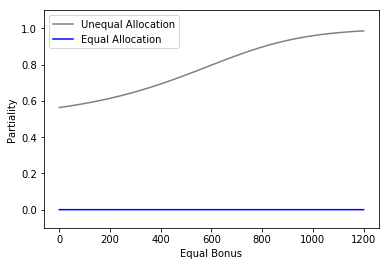

In [12]:
getJudgePartiality = [JudgePartiality (alphaPartial, numberOfAgents, alphaAI, beta, judgePrior) for alphaAI in alphaAIList]

probOfPartial_total = getProbOfPartial_total(getJudgePartiality, getActionExpectedUtilityGivenWeight, alphaAIList)

probOfPartial_unequalBonus = getProbOfPartial_Action(probOfPartial_total, alphaAIList, "Action1")
probOfPartial_equalBonus = getProbOfPartial_Action(probOfPartial_total, alphaAIList, "ActionEqual")

probOfPartial_unequalBonus_Summarized = summarizeProb(probOfPartial_unequalBonus, alphaAIList, equalBonus)
probOfPartial_equalBonus_Summarized = summarizeProb(probOfPartial_equalBonus, alphaAIList, equalBonus)

plt.plot(equalBonus, probOfPartial_unequalBonus_Summarized, color='grey', label = 'Unequal Allocation')
plt.plot(equalBonus, probOfPartial_equalBonus_Summarized, color='blue', label = 'Equal Allocation')
plt.legend(loc='upper left')
plt.ylabel("Partiality")
plt.xlabel("Equal Bonus")
plt.ylim(-0.1,1.1)
plt.show()

# Result of Figure 1-d, Constructed Social Utility

### AlphaVector = [1,1]

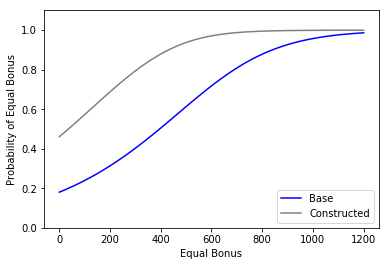

In [13]:
fullConstructedProb = getFullConstructedProb(getConstructedUtility, getActionProbabilityGivenAlpha, alphaAIList, alphaPA, probOfPartial_total, baseUtilityDict)

equalBonusConstructedProb = getConstructedProb_Action(fullConstructedProb, alphaAIList, "ActionEqual")
equalBonusConstructedProb_Summarized = summarizeProb(equalBonusConstructedProb, alphaAIList, equalBonus)

plt.plot(equalBonus, equalBonusProb_Summarized, color='blue', label = 'Base')
plt.plot(equalBonus, equalBonusConstructedProb_Summarized, color='grey', label = 'Constructed')
plt.legend(loc='lower right')
plt.ylabel("Probability of Equal Bonus")
plt.xlabel("Equal Bonus")
plt.ylim(0,1.1)
plt.show()

# Figure2: 

In [14]:
numberOfAgents = 2
beta = 0.003
alphaPartial = 6
alphaPA = 1350
judgePrior = 0.5
effort = [absoluteEffort, absoluteEffort]

equalBonus = [0, 100, 500, 1000, 1100]
weightImpartial = [1, 1]

probDicList = createProbDicList(1000, 100, equalBonus, numberOfAgents)
getActionExpectedUtilityGivenWeight = [BaseDecisionMaker(probabDict, effort, beta, numberOfAgents) for probabDict in probDicList]

In [15]:
weightImpartial = [1, 1]
baseUtilityDict = getBaseUtilityDic(getActionExpectedUtilityGivenWeight, weightImpartial, alphaAIList)


# partiality
getJudgePartiality = [JudgePartiality (alphaPartial, numberOfAgents, alphaAI, beta, judgePrior) for alphaAI in alphaAIList]
probOfPartial_total = getProbOfPartial_total(getJudgePartiality, getActionExpectedUtilityGivenWeight, alphaAIList)

probOfPartial_unequalBonus = getProbOfPartial_Action(probOfPartial_total, alphaAIList, "Action1")
probOfPartial_equalBonus = getProbOfPartial_Action(probOfPartial_total, alphaAIList, "ActionEqual")

probOfPartial_unequalBonus_Summarized = summarizeProb(probOfPartial_unequalBonus, alphaAIList, equalBonus)
probOfPartial_equalBonus_Summarized = summarizeProb(probOfPartial_equalBonus, alphaAIList, equalBonus)


#constructed
fullConstructedProb = getFullConstructedProb(getConstructedUtility, getActionProbabilityGivenAlpha, alphaAIList, alphaPA, probOfPartial_total, baseUtilityDict)

equalBonusConstructedProb = getConstructedProb_Action(fullConstructedProb, alphaAIList, "ActionEqual")
equalBonusConstructedProb_Summarized = summarizeProb(equalBonusConstructedProb, alphaAIList, equalBonus)


fairBonusConstructedProb = getConstructedProb_Action(fullConstructedProb, alphaAIList, "Action1")
fairBonusConstructedProb_Summarized = summarizeProb(fairBonusConstructedProb, alphaAIList, equalBonus)


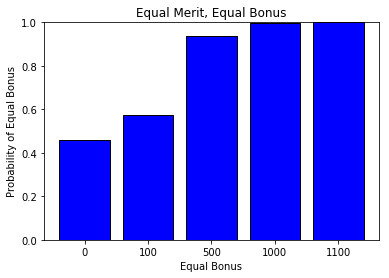

In [16]:
plt.bar([str(bonus) for bonus in equalBonus], equalBonusConstructedProb_Summarized,color='blue',edgecolor='black')
plt.ylabel("Probability of Equal Bonus")
plt.xlabel("Equal Bonus")
plt.title("Equal Merit, Equal Bonus")
plt.ylim((0, 1)) 
plt.show()

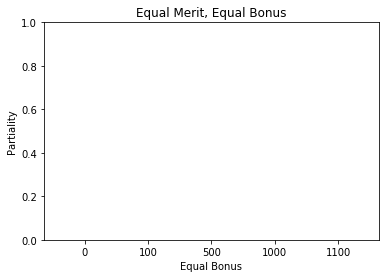

In [17]:
plt.bar([str(bonus) for bonus in equalBonus], probOfPartial_equalBonus_Summarized,color='blue',edgecolor='black')
plt.ylabel("Partiality")
plt.xlabel("Equal Bonus")
plt.title("Equal Merit, Equal Bonus")
plt.ylim((0, 1)) 
plt.show()

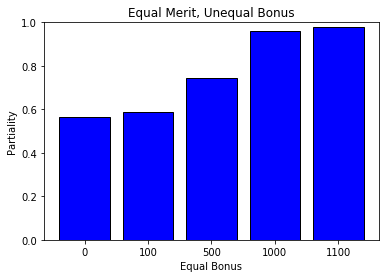

In [18]:
plt.bar([str(bonus) for bonus in equalBonus], probOfPartial_unequalBonus_Summarized,color='blue',edgecolor='black')
plt.ylabel("Partiality")
plt.xlabel("Equal Bonus")
plt.title("Equal Merit, Unequal Bonus")
plt.ylim((0, 1)) 
plt.show()

# Figure 3
## Different Merit Condition: gamma1/ gamma2 = 4



In [19]:
absoluteEffort = 1

In [20]:
numberOfAgents = 2
beta = 0.003
alphaPartial = 6
alphaPA = 1350
judgePrior = 0.5

effort = [4*absoluteEffort, absoluteEffort]

equalBonus = [0, 100, 500, 1000, 1100]
probDicList = createProbDicList(1000, 100, equalBonus, numberOfAgents)

getActionExpectedUtilityGivenWeight = [BaseDecisionMaker(probabDict, effort, beta, numberOfAgents) 
                                       for probabDict in probDicList]


In [21]:
weightImpartial = [1, 1]
baseUtilityDict = getBaseUtilityDic(getActionExpectedUtilityGivenWeight, weightImpartial, alphaAIList)


# partiality
getJudgePartiality = [JudgePartiality (alphaPartial, numberOfAgents, alphaAI, beta, judgePrior) for alphaAI in alphaAIList]
probOfPartial_total = getProbOfPartial_total(getJudgePartiality, getActionExpectedUtilityGivenWeight, alphaAIList)

probOfPartial_fairBonus = getProbOfPartial_Action(probOfPartial_total, alphaAIList, "Action1")
probOfPartial_unfairBonus = getProbOfPartial_Action(probOfPartial_total, alphaAIList, "Action2")
probOfPartial_equalBonus = getProbOfPartial_Action(probOfPartial_total, alphaAIList, "ActionEqual")

probOfPartial_fairBonus_Summarized = summarizeProb(probOfPartial_fairBonus, alphaAIList, equalBonus)
probOfPartial_unfairBonus_Summarized = summarizeProb(probOfPartial_unfairBonus, alphaAIList, equalBonus)
probOfPartial_equalBonus_Summarized = summarizeProb(probOfPartial_equalBonus, alphaAIList, equalBonus)


#constructed
fullConstructedProb = getFullConstructedProb(getConstructedUtility, getActionProbabilityGivenAlpha, alphaAIList, alphaPA, probOfPartial_total, baseUtilityDict)

equalBonusConstructedProb = getConstructedProb_Action(fullConstructedProb, alphaAIList, "ActionEqual")
fairBonusConstructedProb = getConstructedProb_Action(fullConstructedProb, alphaAIList, "Action1")


equalBonusConstructedProb_Summarized = summarizeProb(equalBonusConstructedProb, alphaAIList, equalBonus)
fairBonusConstructedProb_Summarized = summarizeProb(fairBonusConstructedProb, alphaAIList, equalBonus)



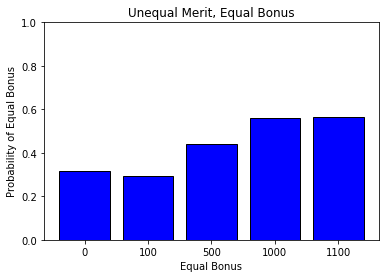

In [22]:
plt.bar([str(bonus) for bonus in equalBonus], equalBonusConstructedProb_Summarized,color='blue',edgecolor='black')
plt.ylabel("Probability of Equal Bonus")
plt.xlabel("Equal Bonus")
plt.title("Unequal Merit, Equal Bonus")
plt.ylim((0, 1)) 
plt.show()

### Action 1: Fair Bonus

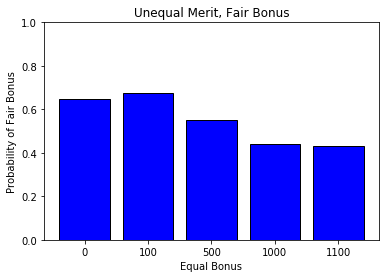

In [23]:
plt.bar([str(bonus) for bonus in equalBonus], fairBonusConstructedProb_Summarized,color='blue',edgecolor='black')
plt.ylabel("Probability of Fair Bonus")
plt.xlabel("Equal Bonus")
plt.title("Unequal Merit, Fair Bonus")
plt.ylim((0, 1)) 
plt.show()

## Partiality

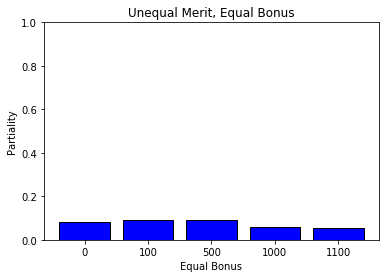

In [24]:
plt.bar([str(bonus) for bonus in equalBonus], probOfPartial_equalBonus_Summarized,color='blue',edgecolor='black')
plt.ylabel("Partiality")
plt.xlabel("Equal Bonus")
plt.title("Unequal Merit, Equal Bonus")
plt.ylim((0, 1)) 
plt.show()

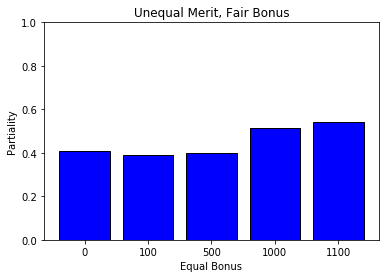

In [25]:
plt.bar([str(bonus) for bonus in equalBonus], probOfPartial_fairBonus_Summarized,color='blue',edgecolor='black')
plt.ylabel("Partiality")
plt.xlabel("Equal Bonus")
plt.title("Unequal Merit, Fair Bonus")
plt.ylim((0, 1)) 
plt.show()

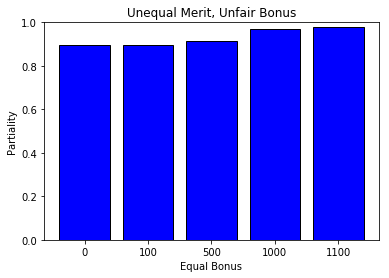

In [26]:
plt.bar([str(bonus) for bonus in equalBonus], probOfPartial_unfairBonus_Summarized,color='blue',edgecolor='black')
plt.ylabel("Partiality")
plt.xlabel("Equal Bonus")
plt.title("Unequal Merit, Unfair Bonus")
plt.ylim((0, 1)) 
plt.show()